# AI Photo Editing with Inpainting

# Edição de fotos com AI Inpainting

In this project we will build a nice web app that allows you to swap out the background of a subject and substitute it with an image generated by Stable Diffusion through a text prompt:

Neste projeto construiremos um ótimo aplicativo web que permite trocar o fundo de um assunto e substituí-lo por uma imagem gerada pelo Stable Diffusion através de um prompt de texto:

<!DOCTYPE html>
<html>
  <head>
    <link rel="stylesheet" href="styles.css" />
  </head>
  <body>
      <img src='https://drive.google.com/uc?id=1X_iX32MIZGqV2vx6BfOjEfwHT32-xB-1&export=download' width="500">
      <script src="script.js"></script>
  </body>
</html>

Let's start by importing what we need:

Vamos começar importando o que precisamos:

In [1]:
!pip install transformers
!pip install diffusers
!pip install torch
!pip install accelerate -U
!pip install gradio -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [33]:
from PIL import Image
import requests
from transformers import SamModel, SamProcessor
from diffusers import DiffusionPipeline, AutoPipelineForText2Image, AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid
import app

import torch
import numpy as np

In [2]:
!pip show accelerate

Name: accelerate
Version: 0.30.1
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## SAM

Complete the following cell by loading the pretrained SAM from Facebook/Meta. Remember to:

1. Move the model to the GPU by adding `.to("cuda")`
2. Add the option `torch_dtype=torch.float16` to your call of AutoPipelineForInpainting.from_pretrained

This cell might take a couple of minutes to load.

##SAM

Complete a célula a seguir carregando o SAM pré-treinado do Facebook/Meta. Lembrar de:

1. Mova o modelo para a GPU adicionando `.to("cuda")`
2. Adicione a opção `torch_dtype=torch.float16` à sua chamada de AutoPipelineForInpainting.from_pretrained

Esta célula pode levar alguns minutos para carregar.

In [4]:
# Load the SAM model as we have seen in the class
# Remeber to load it on the GPU by adding .to("cuda")
# at the end
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)

# Load the SamProcessor using the facebook/sam-vit-base
# checkpoint
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Get the mask

Now that you have loaded SAM, complete the following function that uses SAM to produce a segmentation mask:

### Pegue a máscara

Agora que você carregou o SAM, conclua a seguinte função que usa o SAM para produzir uma máscara de segmentação:

In [5]:
def mask_to_rgb(mask):
    """
    Transforms a binary mask into an RGBA image for visualization
    """

    bg_transparent = np.zeros(mask.shape + (4, ), dtype=np.uint8)

    # Color the area we will replace in green
    # (this vector is [Red, Green, Blue, Alpha])
    bg_transparent[mask == 1] = [0, 255, 0, 127]

    return bg_transparent


def get_processed_inputs(image, input_points):

    # Use the processor to generate the right inputs
    # for SAM
    # Use "image" as your image
    # Use 'input_points' as your input_points,
    # and remember to use the option return_tensors='pt'
    # Also, remember to add .to("cuda") at the end
    inputs = processor(image, input_points=input_points, return_tensors="pt").to(device)

    # Call SAM
    # YOUR CODE HERE
    with torch.no_grad():
      outputs = model(**inputs)

    # Now let's post process the outputs of SAM to obtain the masks
    masks = processor.image_processor.post_process_masks(
       outputs.pred_masks.cpu(),
       inputs["original_sizes"].cpu(),
       inputs["reshaped_input_sizes"].cpu()
    )

    # Here we select the mask with the highest score
    # as the mask we will use. You can experiment with also
    # other selection criteria, for example the largest mask
    # instead of the most confident mask
    best_mask = masks[0][0][outputs.iou_scores.argmax()]

    # NOTE: we invert the mask by using the ~ operator because
    # so that the subject pixels will have a value of 0 and the
    # background pixels a value of 1. This will make it more convenient
    # to infill the background
    return ~best_mask.cpu().numpy()

Now let's test what we have done so far. By executing this cell you should get a visualization of the mask for the following car:

Agora vamos testar o que fizemos até agora. Ao executar esta célula você deverá obter uma visualização da máscara do seguinte carro:

<!DOCTYPE html>
<html>
  <head>
    <link rel="stylesheet" href="styles.css" />
  </head>
  <body>
      <img src='https://drive.google.com/uc?id=11_FKuXN779yw-nqrgXqKUxAv3sH-IKv6&export=download' width="200">
      <script src="script.js"></script>
  </body>
</html>

Let's see what happens in this cell:
1. We open the image of the car and **we resize it to 512 by 512 pixels** (a square image). This makes things simpler for this project
2. We define a few points on the image that indicate where the car is
3. We use the function we have defined to generate a mask using SAM
4. We visualize the mask

The mask should look like this:

Vamos ver o que acontece nesta célula:
1. Abrimos a imagem do carro e **redimensionamos para 512 por 512 pixels** (uma imagem quadrada). Isso torna as coisas mais simples para este projeto
2. Definimos alguns pontos na imagem que indicam onde o carro está
3. Usamos a função que definimos para gerar uma máscara usando SAM
4. Visualizamos a máscara

A máscara deve ficar assim:

<!DOCTYPE html>
<html>
  <head>
    <link rel="stylesheet" href="styles.css" />
  </head>
  <body>
      <img src='https://drive.google.com/uc?id=1_hnH3nZiF0tpj3ka6kXIJaX1q8csBkTf&export=download' width="200">
      <script src="script.js"></script>
  </body>
</html>

If it doesn't or you get errors, double check the code you have completed above and fix it before moving on.

Se isso não acontecer ou você receber erros, verifique o código que você completou acima e corrija-o antes de prosseguir.

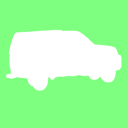

In [6]:
img_url="https://drive.google.com/uc?id=11_FKuXN779yw-nqrgXqKUxAv3sH-IKv6&export=download"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB").resize((512, 512))

# These are the coordinates of two points on the car
input_points = [[[150, 170], [300, 250]]]

mask = get_processed_inputs(raw_image, input_points)

Image.fromarray(mask_to_rgb(mask)).resize((128, 128))

## Inpainting

Now that we have completed the SAM setup, let's move to the inpainting setup.

Let's start by loading our inpainting pipeline. We will use the `diffusers/stable-diffusion-xl-1.0-inpainting-0.1` pretrained model and the `AutoPipelineForInpainting` as we have seen in our `diffusers` demo in Lesson 5.

Complete the following code and run it (it might take a few minutes to run):

> **NOTE**: you will probably see a warning similar to ``The config attributes {'decay'...``. Please ignore it. It is a warning generated by the diffusers library that does not constitute a problem for our application

## Pintura

Agora que concluímos a configuração do SAM, vamos passar para a configuração da pintura interna.

Vamos começar carregando nosso pipeline de pintura interna. Usaremos o modelo pré-treinado `diffusers/stable-diffusion-xl-1.0-inpainting-0.1` e o `AutoPipelineForInpainting` como vimos em nossa demonstração de `difusores` na Lição 5.

Preencha o código a seguir e execute-o (pode levar alguns minutos para ser executado):

> **NOTA**: você provavelmente verá um aviso semelhante a ``Os atributos de configuração {'decay'...``. Por favor, ignore isso. É um aviso gerado pela biblioteca de difusores que não constitui problema para nossa aplicação
Enviar feedback
Painéis laterais
Histórico
Salvas

In [7]:
# Load the AutoPipelineForInpainting pipeline
# (remember the diffusers demo in lesson 5)
# The checkpoint we want to use is
# "diffusers/stable-diffusion-xl-1.0-inpainting-0.1"
# Remember to add torch_dtype=torch.float16 as an option

# YOUR CODE HERE
pipeline = AutoPipelineForInpainting.from_pretrained("diffusers/stable-diffusion-xl-1.0-inpainting-0.1",torch_dtype=torch.float16).to(device)

# This will make it more efficient on our hardware
pipeline.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


Now complete the following function that gets in input:
1. The raw image
2. The mask generated by SAM (a numpy array)
3. The text prompt for the infill
4. An optional negative prompt
5. An optional seed for repeatibility
6. The Classifier-Free Guidance Scale (CFGS). If you don't remember what this is, refer to the Text Conditioning explanation in Lesson 5

Agora complete a seguinte função que entra na entrada:
1. A imagem bruta
2. A máscara gerada pelo SAM (um array numpy)
3. O prompt de texto para o preenchimento
4. Um prompt negativo opcional
5. Uma semente opcional para repetibilidade
6. Escala de Orientação Livre de Classificador (CFGS). Se você não se lembra do que é isso, consulte a explicação do Condicionamento de Texto na Lição 5

In [8]:
def inpaint(raw_image, input_mask, prompt, negative_prompt=None, seed=74294536, cfgs=7):

    mask_image = Image.fromarray(input_mask)

    rand_gen = torch.manual_seed(seed)

    # Use the pipeline we have created in the previous cell
    # Use "prompt" as prompt,
    # "negative_prompt" as the negative prompt,
    # raw_image as the image,
    # mask_image as the mask_image,
    # rand_gen as the generator and
    # cfgs as the guidance_scale

    image = pipeline(
        # YOUR CODE HERE
        prompt=prompt,
        image=raw_image,
        mask_image=mask_image,
        negative_prompt=negative_prompt,
        seed=seed,
        cfgs=cfgs
    ).images[0]

    return image

Let's test our inpainting on the mask we have obtained earlier with SAM:

Vamos testar nossa pintura na máscara que obtivemos anteriormente com SAM:

In [9]:
prompt = "a car driving on Mars. Studio lights, 1970s"
negative_prompt = "artifacts, low quality, distortion"

image = inpaint(raw_image, mask, prompt, negative_prompt)

  0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Let's have a look at what we have produced:

Vamos dar uma olhada no que produzimos:

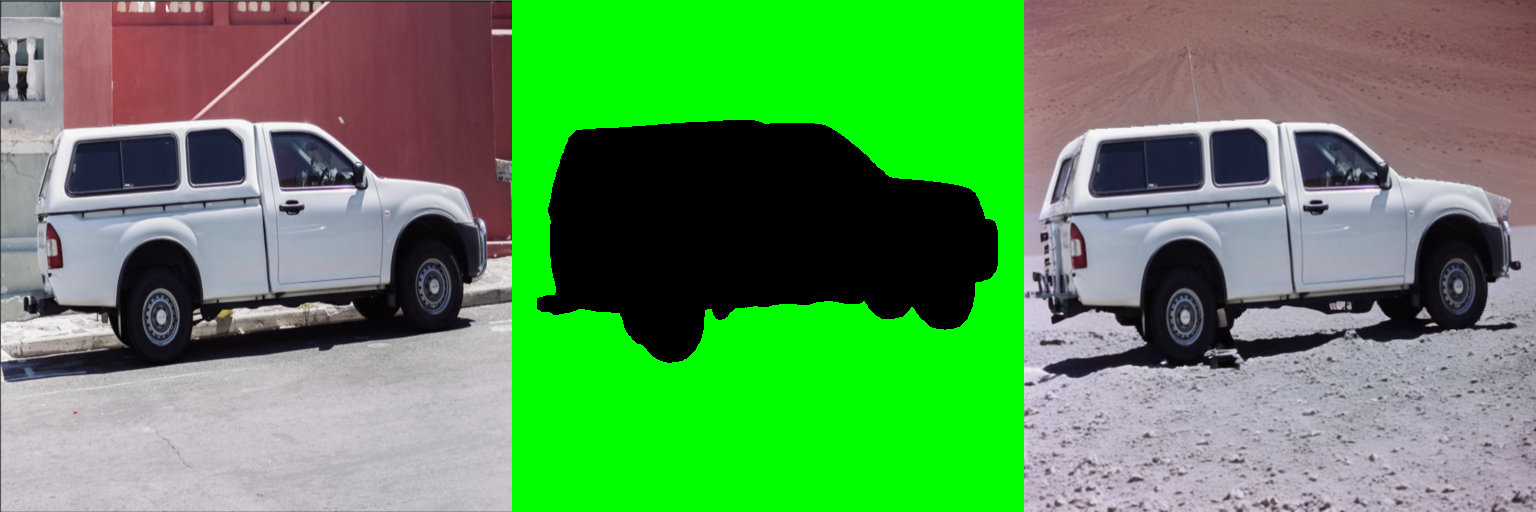

In [10]:
fig = make_image_grid([raw_image, Image.fromarray(mask_to_rgb(mask)), image.resize((512, 512))], rows=1, cols=3)
fig

## Interactive app

To make things a bit more fun, we have prepared an interactive app for you that uses the code you have completed and allow you to upload an image, run SAM, and generate the new background through a text prompt.

Simply execute the following cell. The output will contain a preview of the app: **DO NOT USE IT**. Instead, you will also see a link similar to this:

## Aplicativo interativo

Para tornar as coisas um pouco mais divertidas, preparamos para você um aplicativo interativo que usa o código que você completou e permite fazer upload de uma imagem, executar o SAM e gerar o novo plano de fundo por meio de um prompt de texto.

Basta executar a seguinte célula. A saída conterá uma prévia do aplicativo: **NÃO USE**. Em vez disso, você também verá um link semelhante a este:

<!DOCTYPE html>
<html>
  <head>
    <link rel="stylesheet" href="styles.css" />
  </head>
  <body>
      <img src='' width="500">
      <script src="script.js"></script>
  </body>
</html>

Click on the second link (the public URL), from there you will be able to use the app much more comfortably.

> NOTE: if for any reason you need to stop the app, click on the stop icon of the jupyter interface:

Clique no segundo link (a URL pública), a partir daí você poderá usar o aplicativo com muito mais conforto.

> NOTA: se por algum motivo você precisar parar o aplicativo, clique no ícone de parada da interface do jupyter:

<!DOCTYPE html>
<html>
  <head>
    <link rel="stylesheet" href="styles.css" />
  </head>
  <body>
      <img src='https://drive.google.com/uc?id=1P5TeuLYx6KmE1eQmIzhgZaSCi0E0Vovs&export=download' width="500">
      <script src="script.js"></script>
  </body>
</html>

then **execute the next cell containing the code `my_app.close`**

então **execute a próxima célula contendo o código `my_app.close`**


In [ ]:
my_app = app.generate_app(get_processed_inputs, inpaint)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://3967c5fc9bda0d9be2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
my_app.close()